# Linear regression example
Based on the work by https://www.kaggle.com/code/sudhirnl7/linear-regression-tutorial.

- We will explore the data for data cleanup and feature engineering first.
- Then we'll explore how to use these prior insights for feature interaction and model performance.

## Import Library and Dataset

In [3]:
# Import library
import pandas  as pd #Data manipulation
import numpy as np #Data manipulation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
plt.style.use('seaborn-whitegrid')

In [5]:
# Import dataset
#path ='dataset/'
path = '../input/'
df_raw = pd.read_csv(path+'insurance.csv')
print('\nNumber of rows and columns in the data set: ',df_raw.shape)
print('')

#Lets look into top few rows and columns in the dataset
df_raw.head()


Number of rows and columns in the data set:  (1338, 7)



,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Data exploration

In [8]:
# Data exploration
#  Start by understanding the data (categorical vs. numeric, what's the range ie. min() and max())
df_raw.describe(include = "all")

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


## Exploratory data analysis

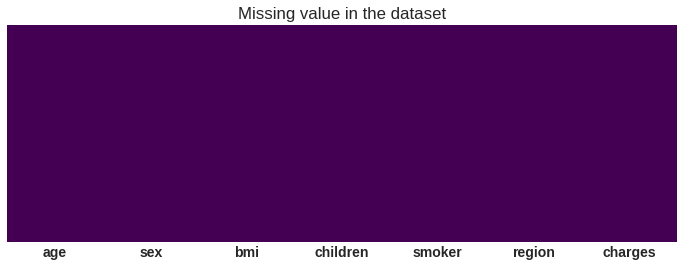

In [40]:
# Check for missing values
plt.figure(figsize=(12,4))
sns.heatmap(df_raw.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing value in the dataset');

# No missing values!

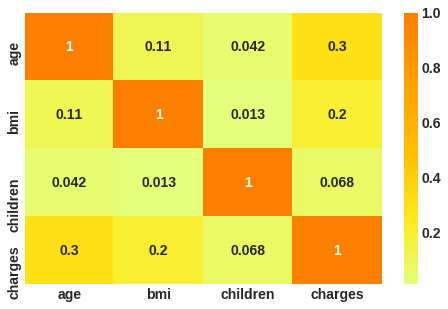

In [41]:
# Check for correlated variables
corr = df_raw.corr()
sns.heatmap(corr, cmap = 'Wistia', annot= True);

# There doesn't seem to be any significant correlation between quantitative variables

Let's take a look at how our target variable behaves when segmented by our categorical variables

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


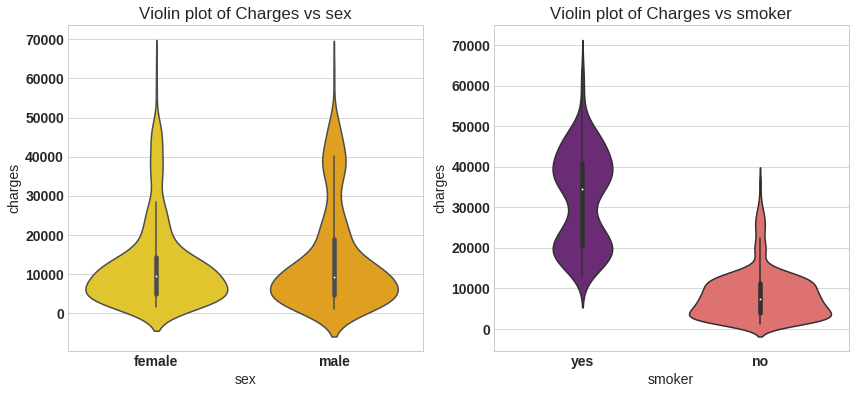

In [42]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.violinplot(x='sex', y='charges',data=df_raw,palette='Wistia',ax=ax)
ax.set_title('Violin plot of Charges vs sex')

ax = f.add_subplot(122)
sns.violinplot(x='smoker', y='charges',data=df_raw,palette='magma',ax=ax)
ax.set_title('Violin plot of Charges vs smoker');

- Left plot: [sex] doesn't seem to have any particular effect on the [changes] variable.
- Right plot: There's definitely a difference between the charges for smokers vs non-smokers. Notice that the [charges] variable is bimodal when restricted to the [Smoker] = "yes" subsample, which indicates we might be able to further separate this population into two more groups (as we'll see shortly).

Next let's see how # of children affects the target variable:

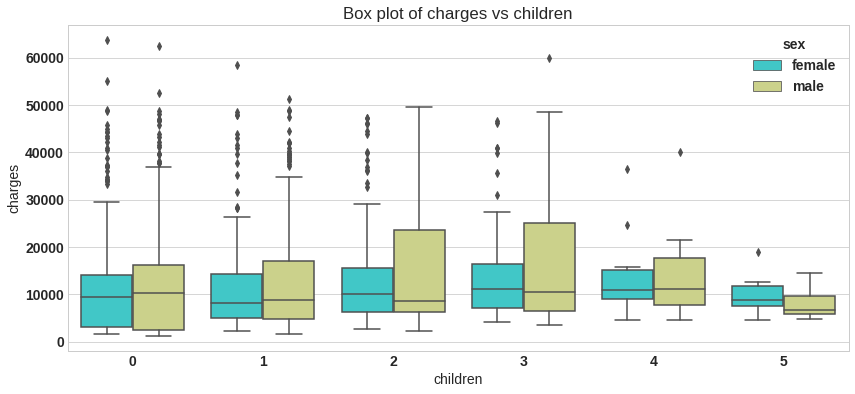

In [10]:
plt.figure(figsize=(14,6))
sns.boxplot(x='children', y='charges',hue='sex',data=df_raw,palette='rainbow')
plt.title('Box plot of charges vs children');

In [44]:
print(df_raw['children'].value_counts())

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64


Number of children doesn't seem to be significant, although there's some bias for samples where [# of children >= 4] -- this might be caused by a smaller amount of samples for the latter ones. If this is the case, we might want to explore including all samples where [# of children] >= 3 in a single categorical bucket ("3 or more").

In [45]:
df_raw['children_bucket'] = np.where(df_raw['children'] == 0, 'child0',
                        np.where(df_raw['children'] == 1, 'child1', 
                        np.where(df_raw['children'] == 2, 'child2', 'child3+')))

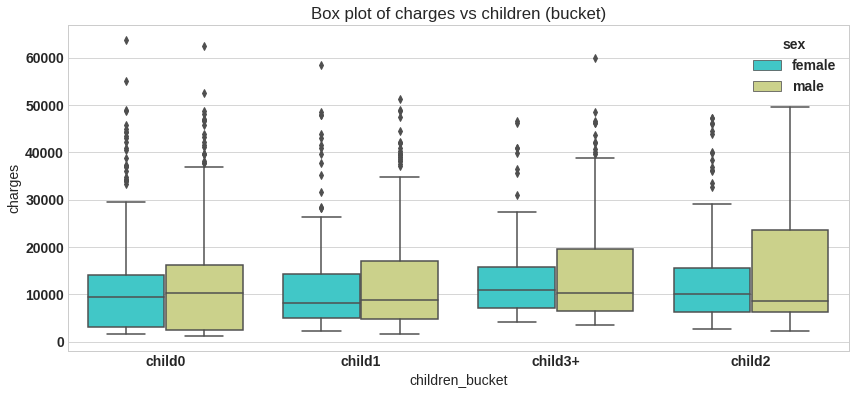

In [46]:
plt.figure(figsize=(14,6))
sns.boxplot(x='children_bucket', y='charges',hue='sex',data=df_raw,palette='rainbow')
plt.title('Box plot of charges vs children (bucket)');

As expected, we have only a very small sample for values higher than 3 in [# of children] variable, so we'll explore creating a categorical variable out of the [children] original variable. This we'll explore after fitting our first model without any feature engineering.

Finally, let's explore some relationships between our quantitative variables, including a color dimension for our categorical variables:

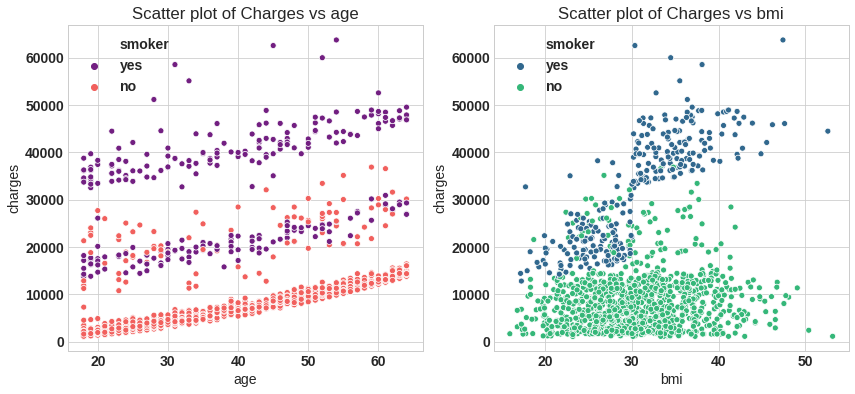

In [47]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.scatterplot(x='age',y='charges',data=df_raw,palette='magma',hue='smoker',ax=ax)
ax.set_title('Scatter plot of Charges vs age')

ax = f.add_subplot(122)
sns.scatterplot(x='bmi',y='charges',data=df_raw,palette='viridis',hue='smoker')
ax.set_title('Scatter plot of Charges vs bmi')
plt.savefig('sc.png');

There's a clear interaction between [smoker] and [bmi] that we'll want to include into the model. On the other hand there's a clear separation within the smoker variable that is causing two clusters in charges. Otherwise it seems like there's a positive correlation between [age] and the target variable [charges] which seems to be pretty consistent among the different clusters (non-smokers, smokers cluster 1, and smokers cluster 2).

**What could be causing this separation within the smokers group along the [charges] variable?** As can be seen from the plot on the right, it seems like there's a hard cut between bmi less than 30 and bmi more than 30, so it might be a good idea to include such a variable into our model upfront. (In practice this is the kind of insights you'd get from the business understanding part of the data science pipeline).

In [48]:
df_raw['bmi_more_than_30'] = np.where(df_raw['bmi'] < 30, 0, 1)

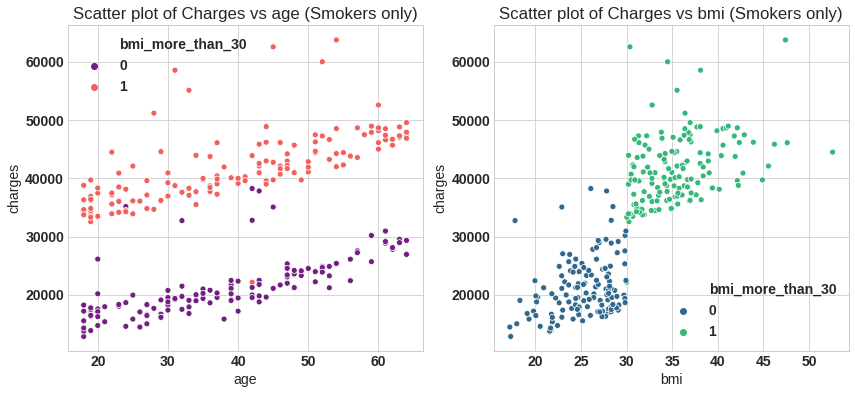

In [49]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.scatterplot(x='age',y='charges',data=df_raw[df_raw.smoker == "yes"],palette='magma',hue='bmi_more_than_30',ax=ax)
ax.set_title('Scatter plot of Charges vs age (Smokers only)')

ax = f.add_subplot(122)
sns.scatterplot(x='bmi',y='charges',data=df_raw[df_raw.smoker == "yes"],palette='viridis',hue='bmi_more_than_30')
ax.set_title('Scatter plot of Charges vs bmi (Smokers only)')
plt.savefig('sc.png');

For the non-smoker population, there's a set of points that clearly deviates from the overall population. By plotting with different color codes (out of the categorical variables), there's no clear criteria to tell them appart from the main cloud of points:

Text(0.5,1,'Scatter plot of Charges vs age')

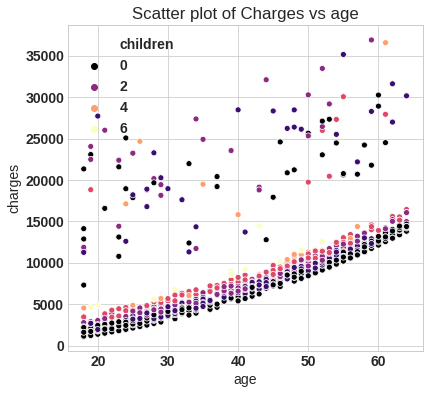

In [50]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.scatterplot(x='age',y='charges',data=df_raw[df_raw.smoker == "no"],palette='magma',hue='children',ax=ax)
ax.set_title('Scatter plot of Charges vs age')

It might be a good idea to separate these points from the data set - in practice you might want to check in with the business to understand why these points differ from the others and this might reveal that we need some more features into our model. For the moment we'll just drop them.

In [51]:
# We'll revisit this problem in the outlier detection module. For the moment let's just apply a simple rule based on the observed values: 

df_raw['outlier'] = (df_raw.charges > 5000 + 15000/70 * df_raw.age) * df_raw.smoker == "no"

Text(0.5,1,'Scatter plot of Charges vs age')

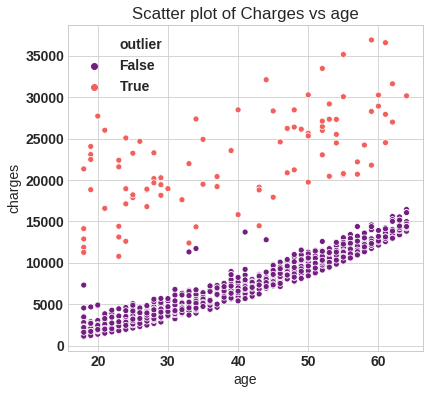

In [52]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.scatterplot(x='age',y='charges',data=df_raw[df_raw.smoker == "no"],palette='magma',hue='outlier',ax=ax)
ax.set_title('Scatter plot of Charges vs age')

In [53]:
df = df_raw[df_raw.outlier == False]

## Data preprocessing
We'll start by encoding categorical variables and splitting the data into a training set and a validation set:

In [54]:
# Dummy variable
categorical_columns = ['sex','children_bucket', 'smoker', 'region'] # we're not including the [bmi_more_than_30] variable since it's already encoded
df_encode = pd.get_dummies(data = df, prefix = 'cat', prefix_sep='_',
               columns = categorical_columns,
               drop_first =True,
               dtype='int8')


print(df_encode.head())

   age    bmi      ...        cat_southeast  cat_southwest
0   19  27.90      ...                    0              1
1   18  33.77      ...                    1              0
2   28  33.00      ...                    1              0
4   32  28.88      ...                    0              0
5   31  25.74      ...                    1              0

[5 rows x 14 columns]


In [55]:
# Let's include the smoker AND high bmi interaction term
df_encode['cat_smoker_and_bmi30'] = df_encode['cat_yes'] * df_encode['bmi_more_than_30']

In [56]:
# Split data into training and test set
from sklearn.model_selection import train_test_split
X = df_encode.drop('charges',axis=1) # Independet variable
y = df_encode['charges'] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=23)

## Modeling
We'll try out first an OLS model with interaction between the [smoker] and [bmi_gt_30] variable, and [age].

Then we'll try out a Lasso without any sort of feature selection in order to see if we get the same result or better than the first one.

In [57]:
# Model 1
mod1_features = ['age','cat_yes', 'cat_smoker_and_bmi30']
X_train_1 = X_train[mod1_features]
X_test_1 = X_test[mod1_features]

# Scikit Learn module
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_1,y_train) # Note: x_0 =1 is no need to add, sklearn will take care of it.

#Parameter
#sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
#parameter_df = parameter_df.join(pd.Series(sk_theta, name='Sklearn_theta'))
#parameter_df

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [58]:
# Evaluate my model
y_pred_1 = lin_reg.predict(X_test_1)

#   Evaluvation: MSE
from sklearn.metrics import mean_squared_error
J_mse_sk = mean_squared_error(y_pred_1, y_test)
print('R2 on test set: ',  str(lin_reg.score(X_test_1, y_test)))

R2 on test set:  0.9635264680581529


A 96% R2 is pretty good. We'll need to check if our assumptions hold, i.e. linearity, normality of the residuals and homoscedasticity.

## Assumption check
We'll verify that the model assumptions hold by residual analysis

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


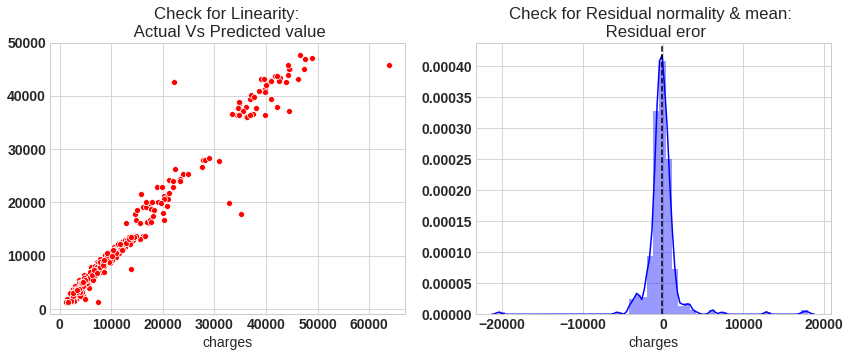

In [59]:
# Let's check out if our assumptions hold via residual analysis
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(y_test,y_pred_1,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred_1),ax=ax,color='b')
ax.axvline((y_test - y_pred_1).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

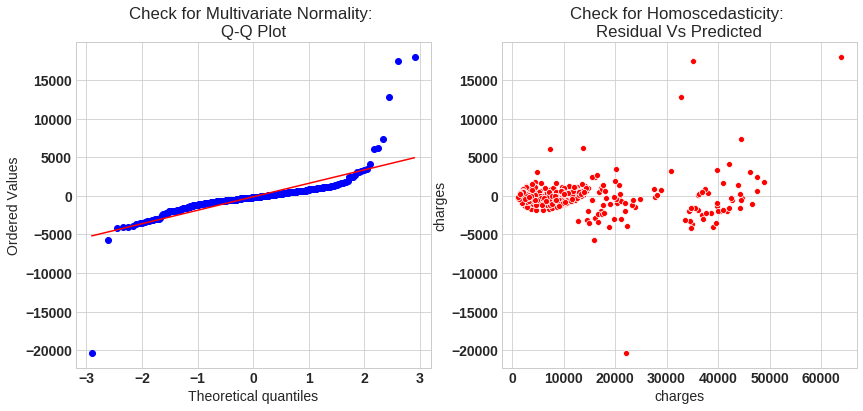

In [60]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y_test - y_pred_1),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y_test - y_pred_1), x= y_test, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

In [61]:
# Check for Multicollinearity
#Variance Inflation Factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_1.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_1.values, i)
                          for i in range(len(X_train_1.columns))]
  
print(vif_data)

                feature       VIF
0                   age  1.238421
1               cat_yes  2.452127
2  cat_smoker_and_bmi30  2.222361


1. Linearity seems to hold well enough.
2. Our residuals are nicely centered around 0, although there seems to be some outliers, especially a couple of values our model is underestimating.
3. Our residuals are fairly normal, as we can see from the qqplot, with the exception of the outliers we mentiones before. We might want to remove these outliers and fit our model again, then test for normality with a Shapiro Wilk test.
4. Homoscedasticity kind of holds, but there's definitely more variance in both smoker samples (clusters 1 and 2), both with low as well as high bmi.
5. There is no multicolinearity (VIF < 5)